# 루브릭
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가? 작성한 노트북을 캐글에 제출했다.
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가? 제출한 주피터노트북 파일이 캐글 커널 환경에서도 에러 없이 동작하며, 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가? 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

## 0. Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno # 결측데이터 확인

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb # 회귀모델
import lightgbm as lgb # 회귀모델

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 시각화 그래프 표시
%matplotlib inline
# 레티나 설정 - 폰트 주변이 흐릿하게 보이는 것을 방지해 글씨가 좀 더 선명하게 보임
%config InlineBackend.figure_format = 'retina' 

In [4]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data' # os.getenv: 환경변수 경로 가져오기
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv') # 테스트, 즉 submission 시 사용할 데이터 경로

## 1. 데이터 살펴보기
각 변수들이 나타내는 의미
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

In [5]:
# csv 파일 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [6]:
y = data['price'] # 타겟으로 남기기
del data['price'] # 원래 데이터에서는 제거

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
train_len = len(data) # 추후에 학습데이터만 불러올 수 있는 인덱스로 사용
data = pd.concat((data, sub), axis=0) # train과 test 데이터 합치기

In [8]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

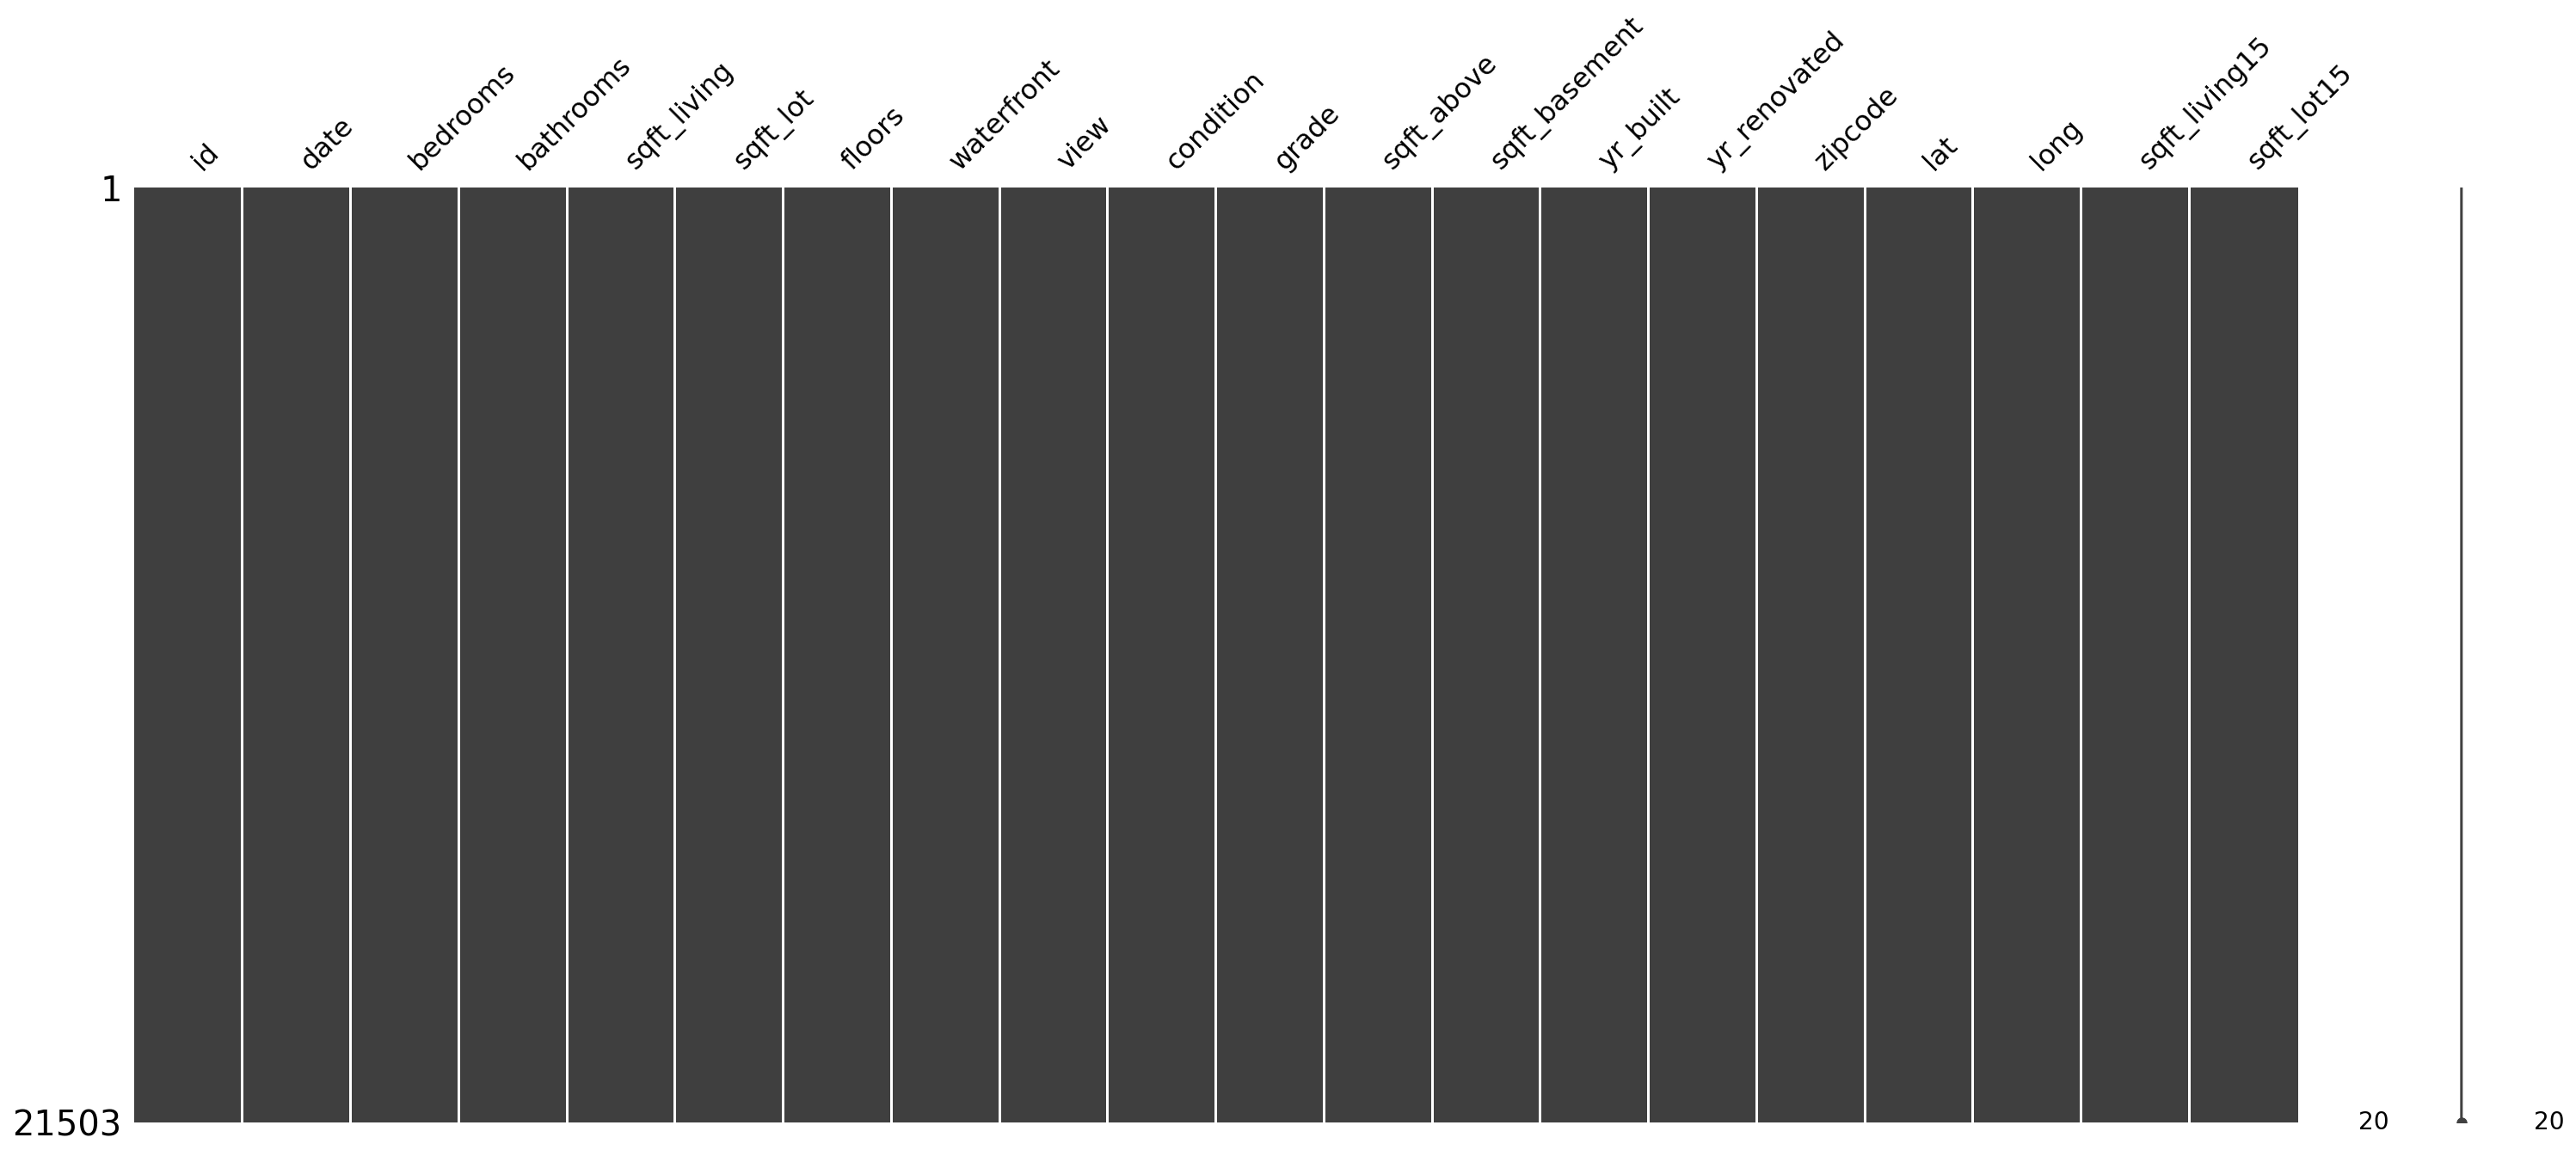

In [9]:
msno.matrix(data)

In [10]:
# 모든 컬럼에 대해서 결측치 개수 확인
for c in data.columns:
    # 컬럼이 결측치인지 확인 (pd.isnull(data['c']))
    # 결측치 데이터만 뽑아내기 (data.loc[null_check, 'c'])
    # 결측치인 데이터의 개수를 세기(len)
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values))) 

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [11]:
sub_id = data['id'][train_len:] # 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장
del data['id'] # 'id' 컬럼은 필요없어서 제거

# str(x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str) 

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

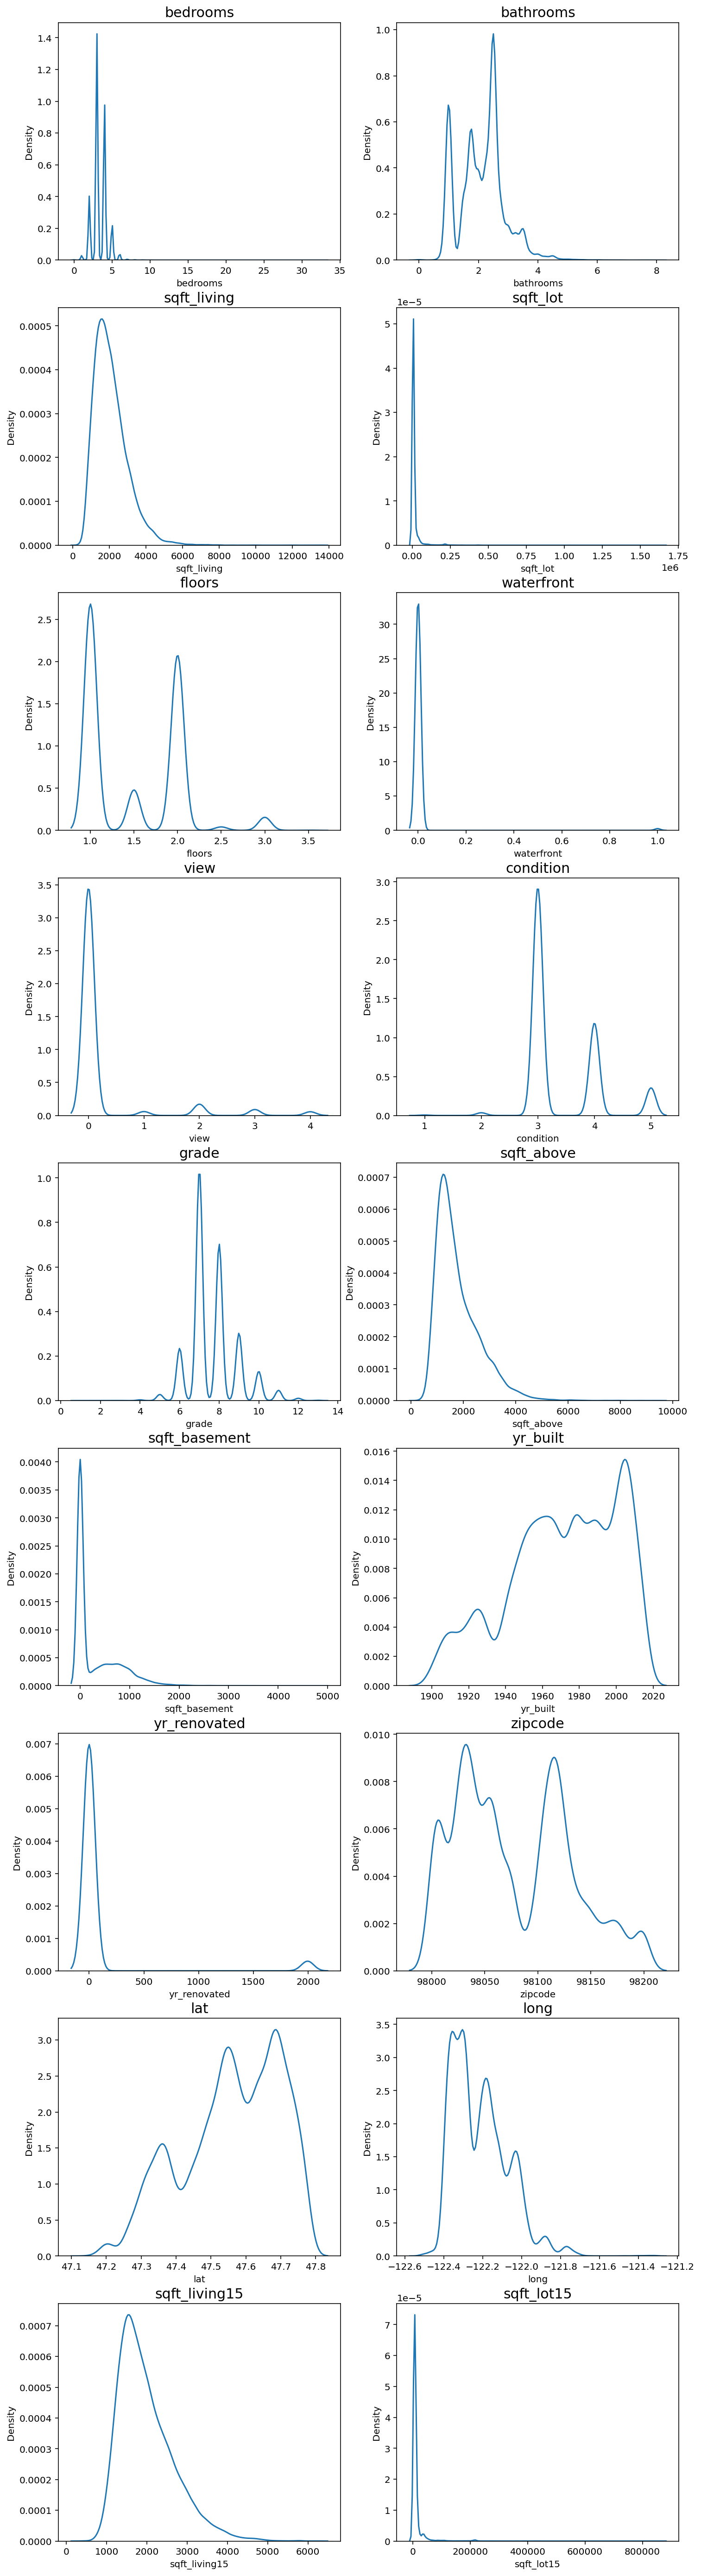

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [13]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'] # 한쪽으로 치우친 경향

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

5


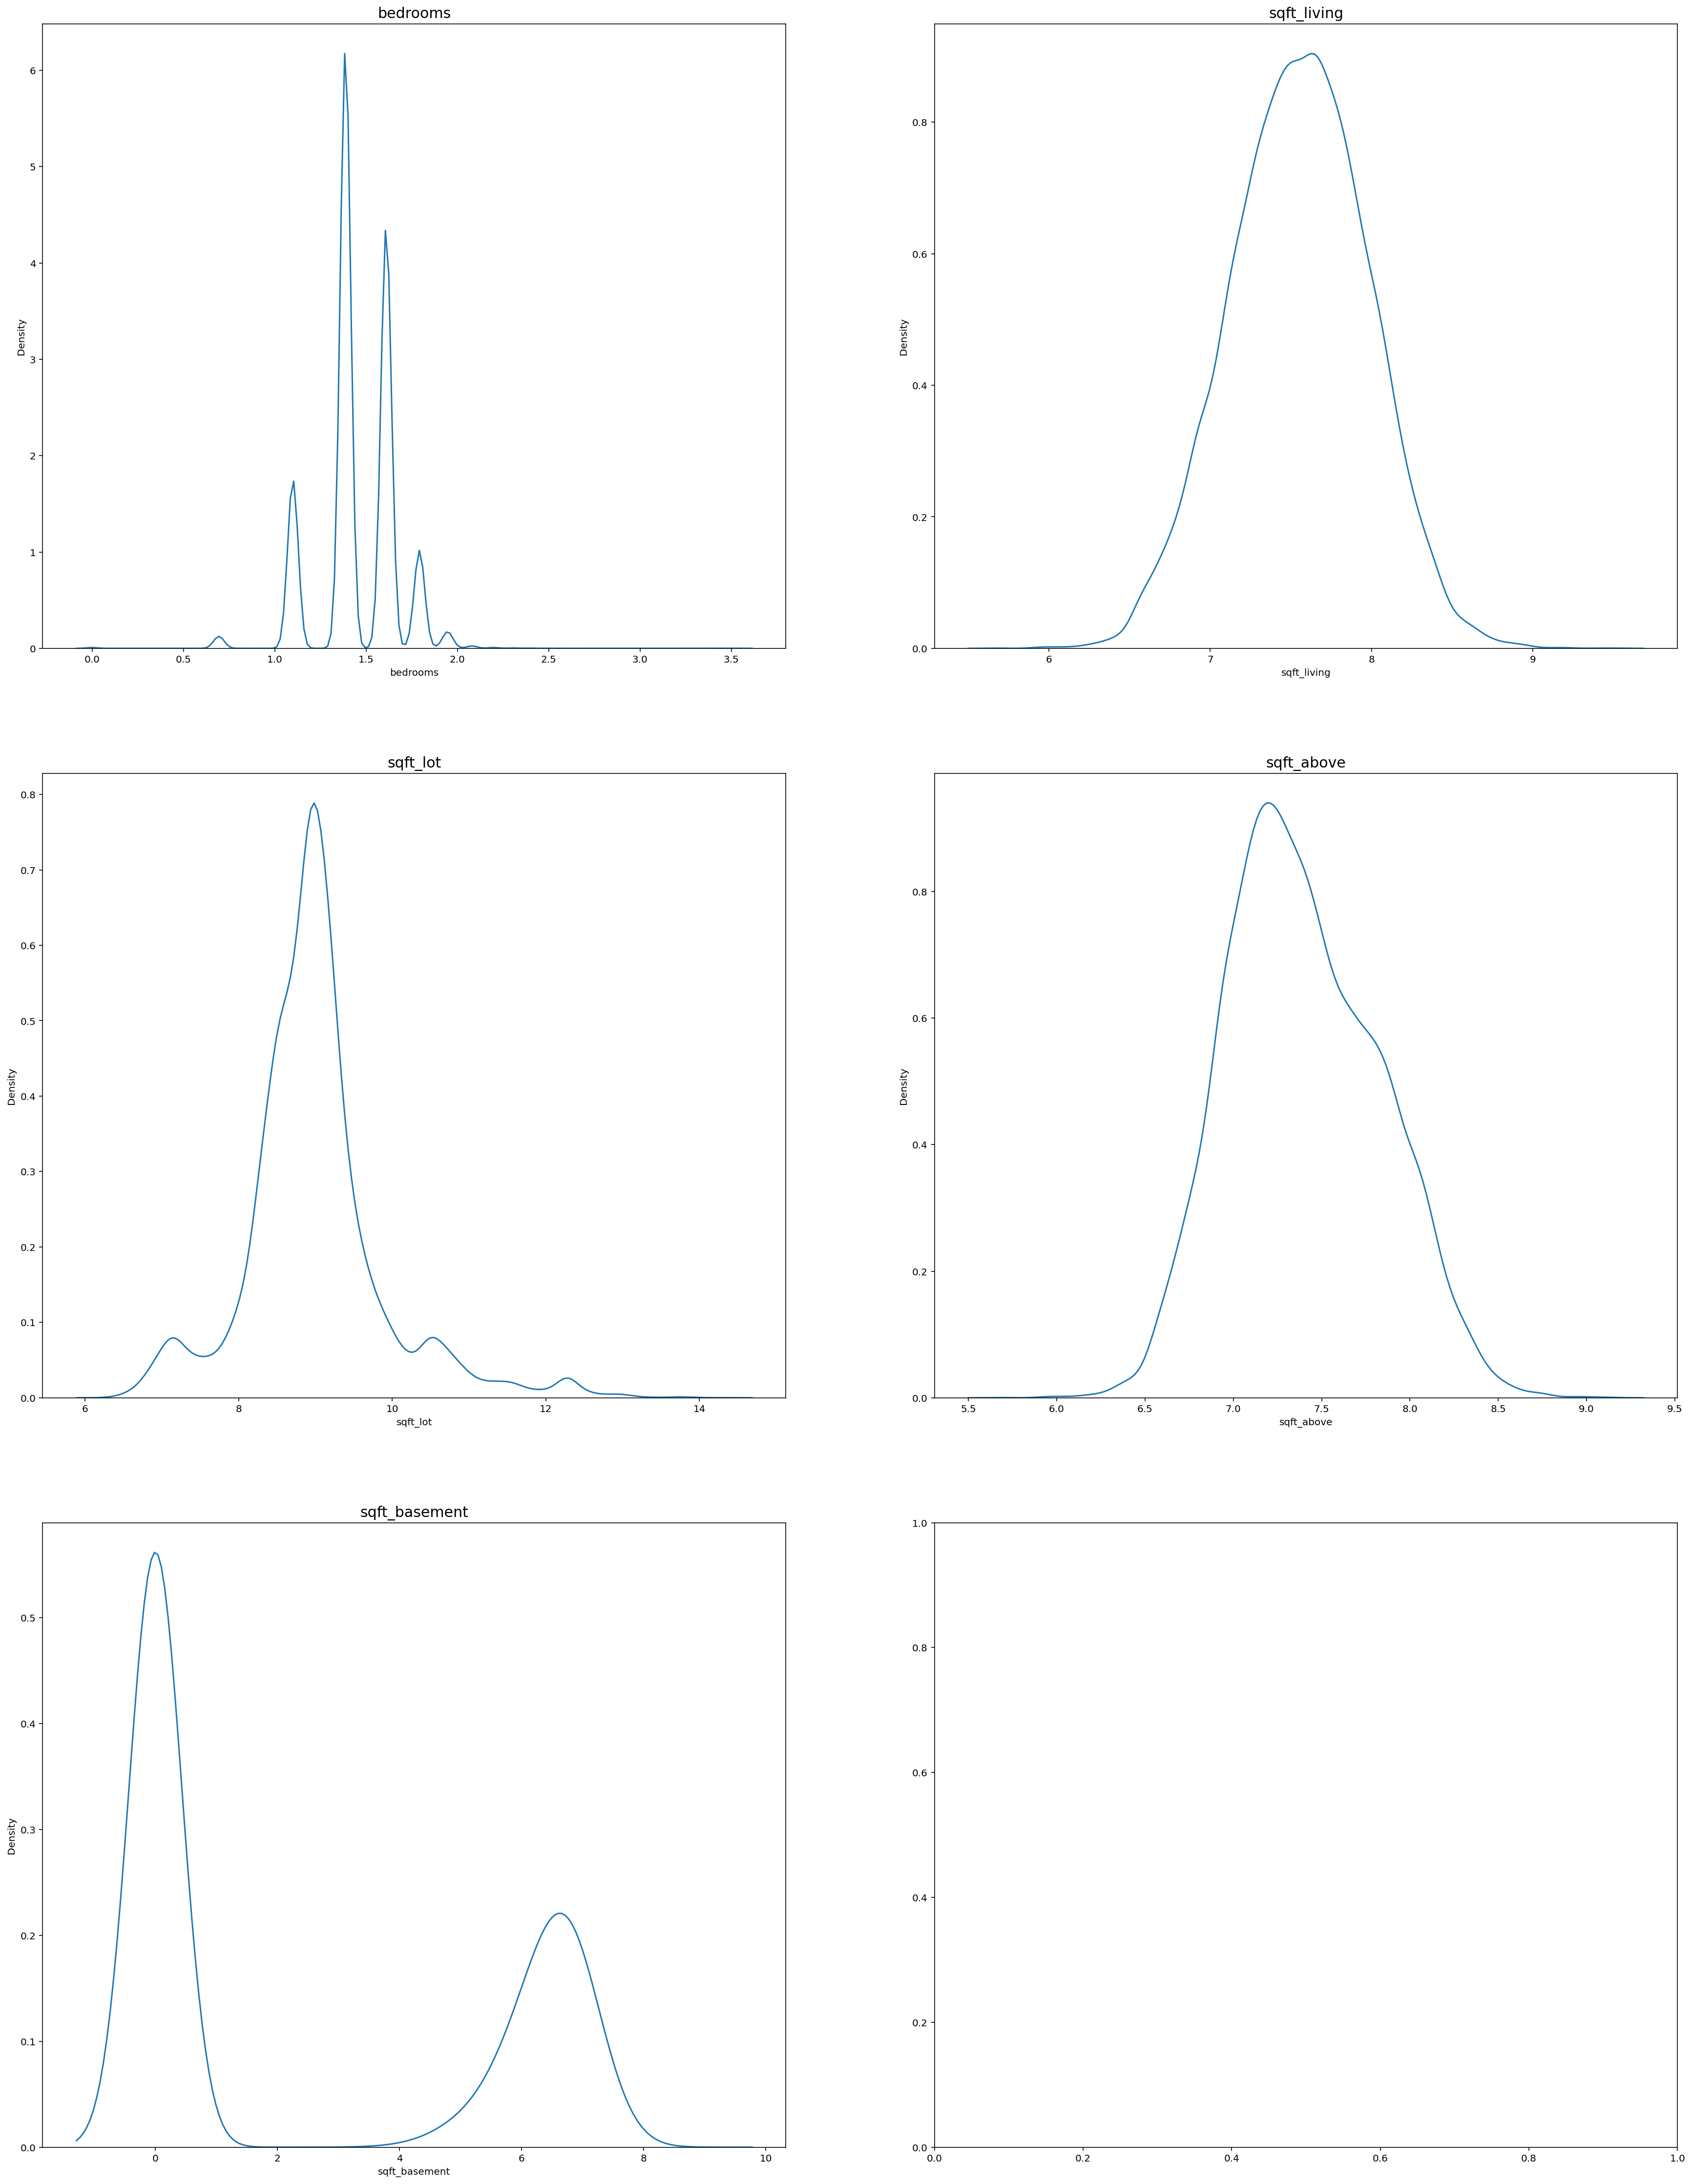

In [14]:
n_vals = len(skew_columns)
print(n_vals)
count = 0

fig, ax = plt.subplots(3, 2, figsize=(30, 40))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

for row in range(3):
    for col in range(2):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 5 :
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  object 
 1   bedrooms       21503 non-null  float64
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  float64
 4   sqft_lot       21503 non-null  float64
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  float64
 11  sqft_basement  21503 non-null  float64
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

### Feature Engieering
기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기

In [16]:
# 예측모델에 넣기위해 date컬럼을 정수형으로 바꾸기
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

In [17]:
sub = data.iloc[train_len:, :] # 제출 테스트용 데이터셋
x = data.iloc[:train_len, :] # 학습데이터

In [18]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 3. 모델링

### Hyperparameter tuning
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.
- `max_depth` : 의사 결정 나무의 깊이, 정수 사용
- `learning_rate` : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- `n_estimators` : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- `num_leaves` : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- `boosting_type` : 부스팅 방식, gbdt, rf 등의 문자열 입력

In [19]:
gboost = GradientBoostingRegressor(random_state=2023)
xgboost = xgb.XGBRegressor(random_state=2023)
lightgbm = lgb.LGBMRegressor(random_state=2023)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [21]:
# RMSE 계산
# np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [22]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=2023, test_size=0.2)
        
        # 모델학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [23]:
# get_scores(models, data, y)

#### 그리드서치
GridSearchCV에 입력되는 인자들
- `param_grid` : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- `scoring` : 모델의 성능을 평가할 지표
- `cv` : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- `verbose` : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- `n_jobs` : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# 그리드서치 계산해주는 함수
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [29]:
data.shape

(21503, 19)

In [30]:
# 그리드서치에 활용할 하이퍼파라미터 셋팅
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [1, 10, 20],
}

model = lightgbm # 모델
my_GridSearch(model, data[:train_len], y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,max_depth,n_estimators,score,RMSLE
8,20,150,-1.618635e+10,127225.605134
5,10,150,-1.622719e+10,127385.993230
7,20,100,-1.632403e+10,127765.512631
4,10,100,-1.636424e+10,127922.786707
3,10,50,-1.723326e+10,131275.530734
6,20,50,-1.727390e+10,131430.224518
2,1,150,-3.479324e+10,186529.449922
1,1,100,-3.851269e+10,196246.498903
0,1,50,-4.787553e+10,218804.781607


### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [34]:
tuning_gboost = GradientBoostingRegressor(random_state=2023)
tuning_xgboost = xgb.XGBRegressor(random_state=2023)
tuning_lightgbm = lgb.LGBMRegressor(max_depth=10,n_estimators=150,random_state=2023)

models = [{'model':tuning_gboost, 'name':'GradientBoosting'}, {'model':tuning_xgboost, 'name':'XGBoost'},
          {'model':tuning_lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [36]:
# 교차검증을 통한 모델 성능 평가 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2023, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [37]:
# 모델별 성능 평가 점수
get_cv_score(models)

Model GradientBoosting CV score : 0.8609
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8823


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [38]:
# 블렌딩 함수
def AveragingBlending(models, x, y, sub_x):
    # 모델 학습
    for m in models : 
        m['model'].fit(x.values, y) 
    
    # 예측
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1) # 모델들 예측 결과값의 평균값 반환

In [39]:
y_pred = AveragingBlending(models, x, y, sub)
print(y_pred)

[ 533664.34064067  439499.20263825 1377108.40693483 ...  458916.56707775
  341206.77256727  427846.49741623]


In [40]:
# 제출 형식에 맞게 필요한 컬럼만 뽑아내기
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [41]:
# csv파일로 추출
my_submission_path = join(data_dir, 'submission.csv')
sub.to_csv(my_submission_path, index=False)
print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# 최종스코어
![screenshot](score.png)

# 회고
모델 성능을 향상시키기 위해서 피쳐엔지니어링과 하이퍼파라미터 튜닝의 중요성을 뼈저리게 느꼈다. 데이터 변수마다의 의미를 정확히 파악하고 전처리를 더 해야겠다. 시간이 생각보다 많이 들어서 다음번에 할 때 더 효율적으로 해결할 수 있는 방법을 모색해봐야겠다. 로그를 씌워서 치우친 분포를 정규분포처럼 만드는 부분이 인상적이었다. 그리드서치하는 부분에서 어떤 하이퍼파라미터를 미리 설정해놔야할지 감이 없었다. 앙상블 모델에 대한 이해를 높일 수 있어서 유익했다.